In [2]:
import numpy as np
import pandas as pd
import csv
import geopandas as gpd
import matplotlib.pyplot as plt
import geoplot as gplt
import mapclassify as mpc
#Reference code: https://medium.com/@erikgreenj/mapping-us-states-with-geopandas-made-simple-d7b6e66fa20d
from shapely.geometry import Point, Polygon

In [3]:
#Importing cleaned and filtered datasets
WOGDFF_states = "WOGDFF_states.csv"
ERADFF_states = "ERADFF_states.csv"

#Creating header list and row list for datasets
"""World of Glass Matrix"""
WOGhead = []
WOGrows = []
"""Electrical Rate Average Matrix"""
ERAhead = []
ERArows = []

#Read in csv file
"""Assembling WOG Matrix Header and Rows"""
with open(WOGDFF_states, 'r') as csvfile: 
    # creating a csv reader object 
    csvreader = csv.reader(csvfile) 
      
    # extracting header names through first row 
    WOGhead = next(csvreader)
  
    # extracting each data row one by one 
    for row in csvreader: 
        WOGrows.append(row) 
            
"""Assembling ERA Matrix Header and Rows"""
with open(ERADFF_states, 'r') as csvfile: 
    # creating a csv reader object 
    csvreader = csv.reader(csvfile) 
      
    # extracting header names through first row 
    ERAhead = next(csvreader)
  
    # extracting each data row one by one 
    for row in csvreader: 
        ERArows.append(row)
        
#Transpose WOG rows to columns
#Reference code: https://note.nkmk.me/en/python-list-transpose/
WOGcolsnp = np.array(WOGrows).T
"""Convert to list for input into DataFrame"""
WOGcols = WOGcolsnp.tolist()

#Creating WOG DataFrame
"""Initializing DataFrame"""
WOGDFF_states = pd.DataFrame()
for i in range(len(WOGhead)):
    WOGDFF_states[WOGhead[i]] = WOGcols[i]
    
#Transpose ERA rows to columns
ERAcolsnp = np.array(ERArows).T
"""Convert to list for input into DataFrame"""
ERAcols = ERAcolsnp.tolist()

#Creating ERA DataFrame
"""Initializing DataFrame"""
ERADFF_states = pd.DataFrame()
for i in range(len(ERAhead)):
    ERADFF_states[ERAhead[i]] = ERAcols[i]

In [4]:
#Creating US map and dataframe
#Reference code: https://jcutrer.com/python/learn-geopandas-plotting-usmaps
#Reference code: https://medium.com/@erikgreenj/mapping-us-states-with-geopandas-made-simple-d7b6e66fa20d
usa = gpd.read_file('./maps/states_21basic/states.shp')

In [5]:
#Creating new row for electrical prices in usa on geopandas map
usa['Electrical Price'] = ERADFF_states['Electrical Price']

In [6]:
#Correctly matching electrical price to state between ERADFF_states and usa
for i in ERADFF_states['State']:
    index_usa = pd.Index(usa['STATE_NAME'])
    index_ERA = pd.Index(ERADFF_states['State'])
    loc_usa = index_usa.get_loc(i)
    loc_ERA = index_ERA.get_loc(i)
    usa['Electrical Price'][loc_usa] = ERADFF_states['Electrical Price'][loc_ERA]

<ipython-input-6-851421b43dfc>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usa['Electrical Price'][loc_usa] = ERADFF_states['Electrical Price'][loc_ERA]


In [7]:
#usa

In [8]:
#Creating lon and lat columns for WOGDFF_states
from geopy.exc import GeocoderTimedOut 
from geopy.geocoders import Nominatim 

In [9]:
#Restrict lon-lat finder to US cities
for i in range(len(WOGDFF_states['City'])):
    WOGDFF_states['City'][i] = WOGDFF_states['City'][i] + " ,US"

In [10]:
#Reference code:https://www.geeksforgeeks.org/how-to-find-longitude-and-latitude-for-a-list-of-regions-or-country-using-python/
# declare an empty list to store latitude and longitude of values of city column 
longitude = [] 
latitude = [] 
   
# function to find the coordinate of a given city  
def findGeocode(city): 
       
    try: 
        geolocator = Nominatim(user_agent="your_app_name") 
          
        return geolocator.geocode(city) 
      
    except GeocoderTimedOut: 
          
        return findGeocode(city)

In [11]:
# each value from city column will be fetched and sent to function find_geocode    
for i in (WOGDFF_states['City']): 
      
    if findGeocode(i) != None: 
           
        loc = findGeocode(i) 
        latitude.append(loc.latitude) 
        longitude.append(loc.longitude) 

    else: 
        latitude.append(np.nan) 
        longitude.append(np.nan) 

In [12]:
#Adding lon-lat column to WOGDFF_states
WOGDFF_states['lon'] = longitude
WOGDFF_states['lat'] = latitude

In [13]:
#Creating GeoDataFrame from WOGDFF_states
#Reference code:https://geopandas.org/gallery/create_geopandas_from_pandas.html
WOGDFF_GDF = gpd.GeoDataFrame(WOGDFF_states, geometry = gpd.points_from_xy(WOGDFF_states.lon, WOGDFF_states.lat))

In [14]:
#Getting rid of Alaska and Hawaii (hahaha)
usa = usa.drop([0])
usa = usa.drop([50])

In [15]:
#Typecasting ELectrical Price values from string to float
for i in range(len(usa['Electrical Price'])):
    usa['Electrical Price'][i+1] = float(usa['Electrical Price'][i+1])

<ipython-input-15-3092466237f2>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usa['Electrical Price'][i+1] = float(usa['Electrical Price'][i+1])


**How was the data appropriately normalized or scaled**

The data for electrical prices was placed into 5 bins corresponding to 5 electrical price ranges.
- See below: scheme defined for k=5 bins on quantiles using mapclassify

In [16]:
scheme = mpc.Quantiles(usa['Electrical Price'], k=5)

**Create clear, labeled and appropriate visualizations**

We produced 3 primary types of maps: Choropleth base maps, Pointplot overplots on polyplots, and Pointplot overplots on the choropleth base maps. Each base map is given an appropriate legend and labeled according to the information it displays.
We also constructed a histogram for glass plant electricity prices in the US: their frequency and industrial electricity rate, assuming statewide industrial electricity prices are charged to the plant.

**Visualizations should be made for exploratory phase of your analysis as well as
for the insights and results from your model**

We created prototypes of the maps before overplotting. (plots 1 and 2 below) We also checked the pointplot maps before performing K-means clustering analysis. Overplotting was done once the prototypes were appropriately passed to the analysis.

Text(0.5, 1.0, 'US Glass Float Lines and Electricity Price')

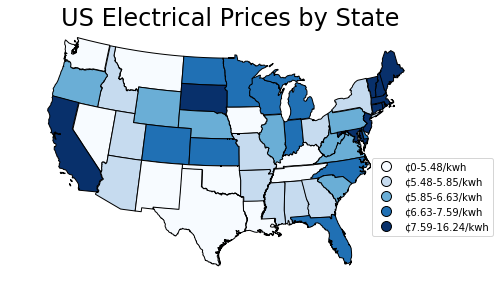

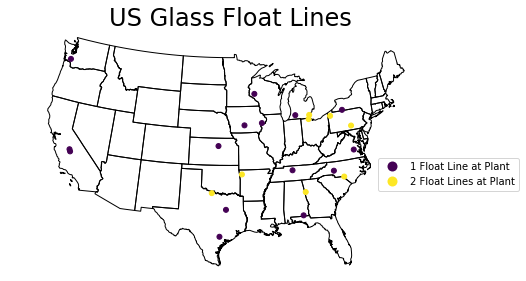

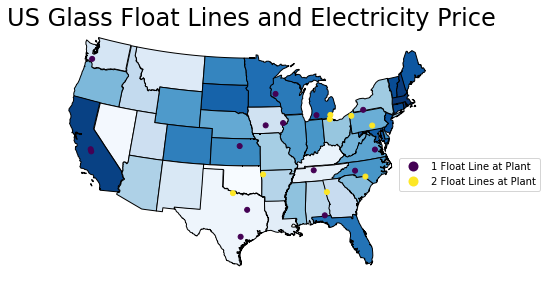

In [20]:
#Plotting WOGDFF onto usa with electrical price chropleth
#Reference code:https://geopandas.org/docs/user_guide/mapping.html
import geoplot.crs as gcrs

#Setting plot bounds
#Reference code:https://residentmario.github.io/geoplot/user_guide/Customizing_Plots.html
extent = usa.total_bounds

"""Creating electrical price choropleth"""
EPC = gplt.choropleth(
    usa, hue=usa['Electrical Price'], scheme=scheme, cmap='Blues', 
    legend=True, projection=gcrs.AlbersEqualArea(),
    edgecolor='black', linewidth=1,
    legend_labels=['¢0-5.48/kwh', '¢5.48-5.85/kwh', '¢5.85-6.63/kwh',
                   '¢6.63-7.59/kwh', '¢7.59-16.24/kwh'],
    extent=extent
                     )
#Title
EPC.set_title('US Electrical Prices by State', fontdict={'fontsize':24})

#Move legend to empty space
#Reference code:https://medium.com/using-specialist-business-databases/creating-a-choropleth-map-using-geopandas-and-financial-data-c76419258746
EPC.get_legend().set_bbox_to_anchor((1.1, 0.5))

"""Creating polyplot of us as basemap"""
usp = gplt.polyplot(usa, projection=gcrs.AlbersEqualArea())

"""Overplotting layers"""
#Reference code:https://residentmario.github.io/geoplot/quickstart/quickstart.html
USA_WOG = gplt.pointplot(WOGDFF_GDF, ax=usp, 
                         hue=WOGDFF_GDF['Number of Lines'], 
                         legend=True, 
                         legend_labels=['1 Float Line at Plant', '2 Float Lines at Plant'],
                         figsize=(8, 8),
                         extent=extent
                        )

#Title
USA_WOG.set_title('US Glass Float Lines', fontdict={'fontsize':24})

#Move Legend to empty space
USA_WOG.get_legend().set_bbox_to_anchor((0.82, 0.5))

"""Underplotting choropleth map"""

EPC_under = gplt.choropleth(
  usa,
  hue=usa['Electrical Price'],
  edgecolor="black",
  linewidth=1,
  cmap="Blues",
  projection=gcrs.AlbersEqualArea(),
  figsize=(8, 8)
)

WOG_overs = gplt.pointplot(
  WOGDFF_GDF,
  hue=WOGDFF_GDF['Number of Lines'],
  limits=(3, 50),
  zorder=2,
  ax=EPC_under,
  extent=extent,
  legend=True,
  legend_labels=['1 Float Line at Plant', '2 Float Lines at Plant']
)

#Move Legend to empty space
WOG_overs.get_legend().set_bbox_to_anchor((0.82, 0.5))

#Title
WOG_overs.set_title('US Glass Float Lines and Electricity Price', 
                   fontdict={'fontsize':24}
                   )